In [1]:

import os
import sys
import importlib
import copy
from collections import defaultdict
sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

from tools_pattern import get_eucledean_dist

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'distribution_123share_210512_random_test'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

# input_graph = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_201114_restricted_z.gz')
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
                                   'mf_grc_model/input_graph_210407_all.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800
z_max = 29800
# GrCs are fully reconstructed and proofread from 90k to 150k
x_min = 105*1000*4
x_max = 135*1000*4
# radius = 200

n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)

def filter_by_len(edges, soma_loc, dendrite_len_threshold):
    if dendrite_len_threshold is None:
        return edges
    ret = []
    for e in edges:
        mf_id, mf_loc = e
        if get_eucledean_dist(soma_loc, mf_loc) <= dendrite_len_threshold:
            ret.append(e)
    return ret

def get_connected_mfs(grc, max_len):
    edges = filter_by_len(grc.edges, grc.soma_loc, max_len)
    mfs = set()
    locs = set()
    for e in edges:
        mfs.add(e[0])
        locs.add(e[1])
    return mfs, locs

def get_prob(in_graph, unique_count=False, count_within_box=True, return_counted=False,
            dendrite_len_threshold=None):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        n += 1
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        mfs_i, _ = get_connected_mfs(grc_i, dendrite_len_threshold)
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
            mfs_j, _ = get_connected_mfs(grc_j, dendrite_len_threshold)
            common_mfs = mfs_i & mfs_j
            hist[len(common_mfs)] += 1
            if len(common_mfs) == 2:
                replication_hist2[grc_i_id] += 1
                common_mfs = tuple(sorted(list(common_mfs)))
                replicated_2shares[common_mfs] += 1
    for k in hist:
        # fix 0 datapoint plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist

input_observed = copy.deepcopy(input_graph)

input_observed.remove_dendrites(min_len=None, max_len=22000)

# input_graph.randomize_graph_by_grc2(
# #     constant_dendrite_length='depth',
#     mf_dist_margin=5000,
#     seed=1,
# )
    
# input_observed.edge_probabilities_by_pos = None
# input_observed.shuffle_edges(
#     seed=0,
#     max_edge_len=60000,
# #     mf_dist_margin=10000,
#     )

hist_data, n_grcs = get_prob(input_observed, count_within_box=True, return_counted=True,
#                             dendrite_len_threshold=25000,
                            )

print(n_grcs)
print(hist_data)
# n_grcs = len(input_graph.grcs)

replication_hist2_list = []
for grc in grc_ids:
    if grc in replication_hist2:
        replication_hist2_list.append((grc, replication_hist2[grc]))
    else:
        replication_hist2_list.append((grc, 0))

replication_hist2_list_sorted = sorted(replication_hist2_list, key=lambda x: x[1])

mpd = MyPlotData()
mpd_count = MyPlotData()
i = 0
for grc_id, count in replication_hist2_list_sorted:
    mpd_count.add_data_point(
        count=count,
        grc_id=grc_id,
        i=i,
        model='Random',
    )
    i += 1


206
defaultdict(<class 'int'>, {0: 508255, 1: 6158, 2: 171, 3: 4})


Height: 4, Aspect: 2


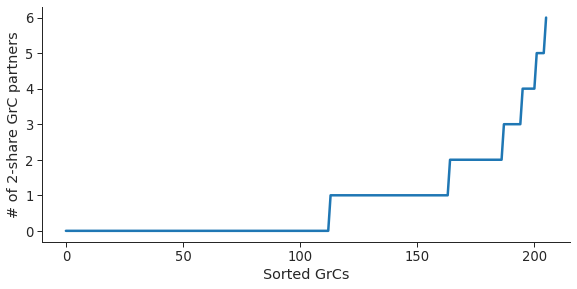

In [2]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='i',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of 2-share GrC partners',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

Height: 4, Aspect: 2


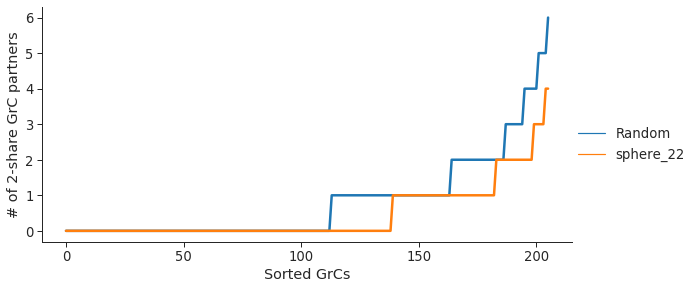

In [4]:

# mpd_count_random = compress_pickle.load('distribution_123share_210512_random.gz')
# mpd_count_random = compress_pickle.load('distribution_123share_210512_random_test.gz')
# mpd_count_random2 = compress_pickle.load('distribution_123share_210512_random_test.gz')

mpd_all = MyPlotData()
mpd_all.append(mpd_count)
# mpd_all.append(compress_pickle.load(
#     'distribution_123share_210512_random_22000_5000.gz').add_key_value('model', '22000_5000'))

mpd_all.append(compress_pickle.load(
    'distribution_123share_210512_random_test_test_X_420000_540000_Z_19800_29800.gz').add_key_value(
    'model', 'sphere_22'))

# mpd_all.append(compress_pickle.load(
#     'sharedist_bouton_210514_random_sphere_15000_X_420000_540000_Z_19800_29800.gz').add_key_value(
#     'model', 'sphere_15'))

# mpd_all.append(compress_pickle.load(
#     'sharedist_bouton_210514_random_sphere_30000_X_420000_540000_Z_19800_29800.gz').add_key_value(
#     'model', 'sphere_30'))

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_all,
    x='i',
    y='count',
    hue='model',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of 2-share GrC partners',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )